# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc

import os, wget

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this 
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=16

In [4]:
start = time.time()

## Load Data

In [5]:
%%time
adata = sc.read(input_file)

CPU times: user 221 ms, sys: 382 ms, total: 603 ms
Wall time: 601 ms


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 1.9 s, sys: 1.39 s, total: 3.29 s
Wall time: 3.28 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1.47 s, sys: 712 ms, total: 2.18 s
Wall time: 2.18 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 503 ms, sys: 99.2 ms, total: 603 ms
Wall time: 596 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.27 s, sys: 0 ns, total: 2.27 s
Wall time: 2.27 s


### Select Most Variable Genes

In [11]:
%%time
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].toarray()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 2.15 s, sys: 251 ms, total: 2.4 s
Wall time: 2.39 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.51 s, sys: 156 ms, total: 1.67 s
Wall time: 1.66 s


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

CPU times: user 9.74 s, sys: 9.07 s, total: 18.8 s
Wall time: 55 s


### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 2.43 s, sys: 325 ms, total: 2.75 s
Wall time: 2.75 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 70.25771117210388


## Cluster & Visualize

### Reduce

In [17]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 2min 7s, sys: 6.69 s, total: 2min 14s
Wall time: 10.6 s


### TSNE + K-means

In [18]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 16min 28s, sys: 634 ms, total: 16min 29s
Wall time: 3min 40s


In [19]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=sc.settings.n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 2min 11s, sys: 1min 31s, total: 3min 43s
Wall time: 14.3 s


... storing 'kmeans' as categorical


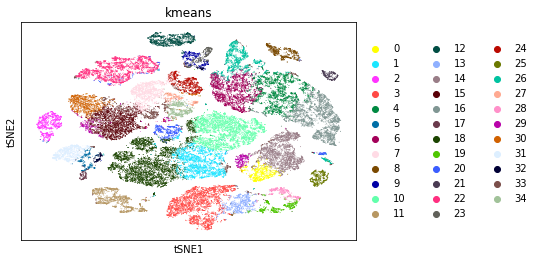

CPU times: user 1.14 s, sys: 40.2 ms, total: 1.18 s
Wall time: 1.17 s


In [20]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

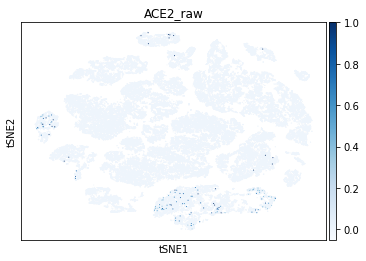

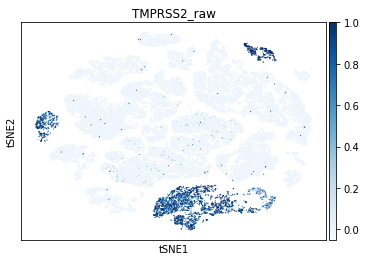

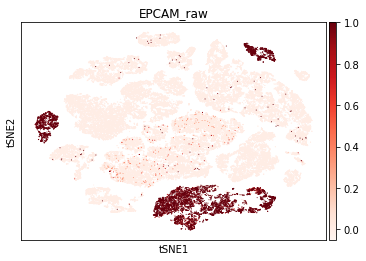

CPU times: user 1.2 s, sys: 27.9 ms, total: 1.22 s
Wall time: 1.21 s


In [21]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

In [22]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 36.7 s, sys: 13.9 s, total: 50.6 s
Wall time: 17.8 s


In [23]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 4min 5s, sys: 1min 43s, total: 5min 49s
Wall time: 1min 37s


In [24]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 13.8 s, sys: 216 ms, total: 14 s
Wall time: 13.9 s


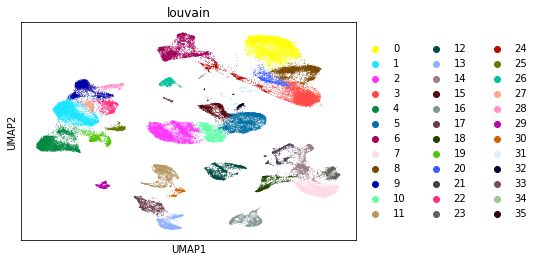

CPU times: user 1.12 s, sys: 4.33 ms, total: 1.13 s
Wall time: 1.12 s


In [25]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

In [26]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 12.6 s, sys: 215 ms, total: 12.9 s
Wall time: 12.8 s


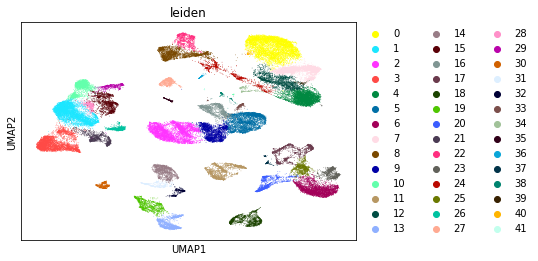

CPU times: user 1.22 s, sys: 11.6 ms, total: 1.23 s
Wall time: 1.23 s


In [27]:
%%time
# Plot
sc.pl.umap(adata, color=["leiden"])

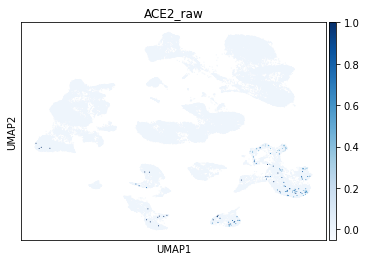

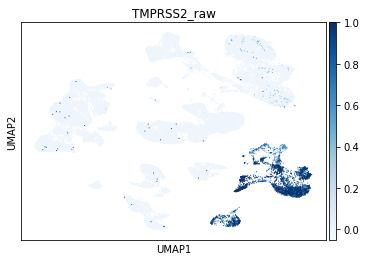

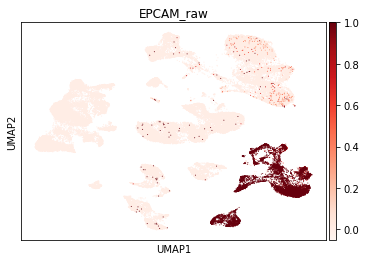

CPU times: user 1.09 s, sys: 13.8 ms, total: 1.1 s
Wall time: 1.08 s


In [28]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest', method='logreg')

CPU times: user 32min 32s, sys: 7min 11s, total: 39min 44s
Wall time: 2min 33s


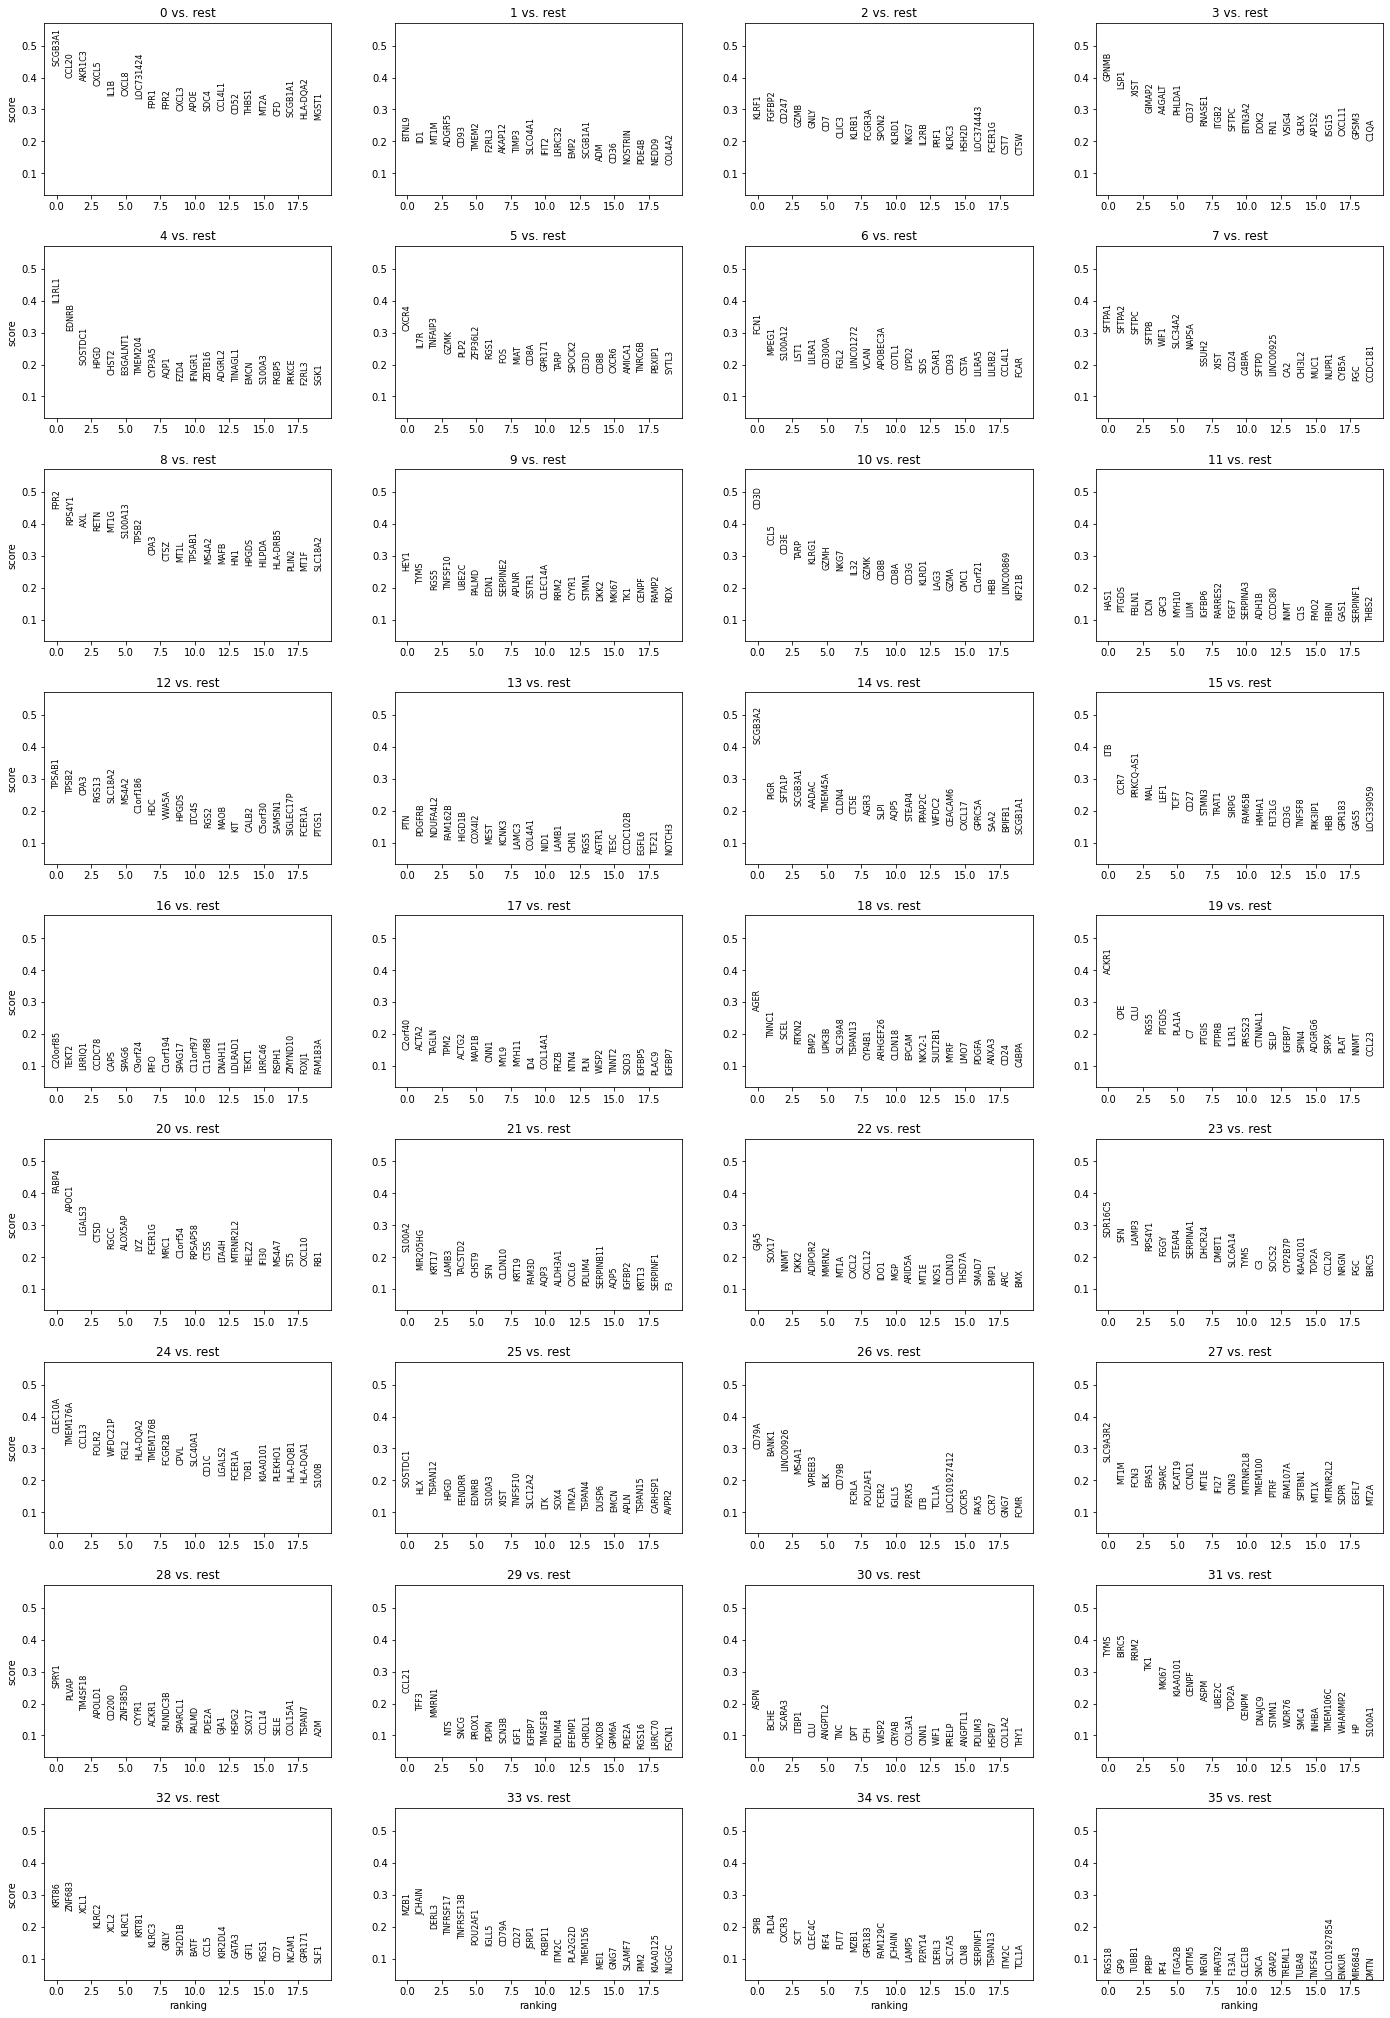

CPU times: user 6.38 s, sys: 131 ms, total: 6.51 s
Wall time: 6.5 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 103 ms


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 50.1 s, sys: 12.3 s, total: 1min 2s
Wall time: 28.5 s


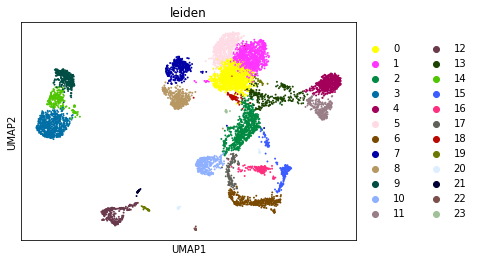

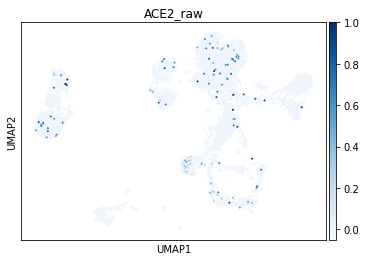

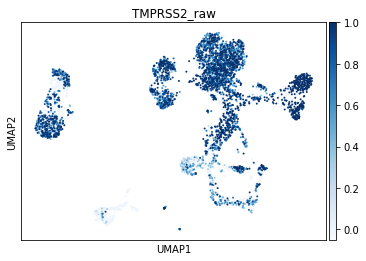

CPU times: user 884 ms, sys: 5.09 ms, total: 889 ms
Wall time: 876 ms


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 29.470316410064697


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 654.0906691551208
